In [1]:
def load_questions(activation_f, question_f, max_size = -1):
    activations_file = "/Users/daniel/ideaProjects/allennlp/" + activation_f
    questions_file = "/Users/daniel/ideaProjects/allennlp/" + question_f
    features = []
    pred_ans = []
    with open(activations_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
            # print(i)
            # print(l[0:100])

            if (max_size > -1 and len(pred_ans) > max_size):
                break

            if i % 2 == 0:
                # print(l)
                data = json.loads(l)
                features.append(data)
            else:
                pred_ans.append(l)

    questions = []
    labels = []
    with open(questions_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
#             print(i)
#             print(l[0:100])
            if i % 3 == 0:
                questions.append({})
                questions[int(i / 3)]["q"] = l
            elif i % 3 == 1:
                questions[int(i / 3)]["p"] = l
            elif i % 3 == 2:
                ans = json.loads(l)
                questions[int(i / 3)]["a"] = [c['text'] for c in ans]
                labels.append(ans[0]['text'])

            if (max_size > -1 and len(labels) > max_size):
                break
    mat = numpy.array(features)

    return (mat, labels, questions, pred_ans)

In [2]:
import json
import numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

(mat, labels, questions, pred_ans) = load_questions("ipython/babi/out3.txt", "ipython/babi/out22.txt", max_size=0)
(mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/babi/out33-adv.txt", "ipython/babi/out22-adv.txt", max_size=-1)

# read the questions and remember question ids:
question_paragraph_id_map = {}
ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/babi-test.json"
with open(ff) as file:
    dataset_json = json.load(file)
    dataset = dataset_json['data']
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                key = qa['question'] + paragraph['context']
                id = qa['id']
                question_paragraph_id_map[key] = id

bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]

basic-deduction -> 9.035845915712434
simple-negation -> 20.300111551383658
agents-motivations -> 24.04645354645355
two-arg-relations -> 52.1950521950522
three-arg-relations -> 67.59088676155083
compound-coreference -> 8.451739352293382
single-supporting-fact -> 35.772348606559156
three-supporting-facts -> 3.8784005754064124
time-reasoning -> 28.775954581718683
basic-coreference -> 4.867682419284248
conjunction -> 27.5323685213614
two-supporting-facts -> 7.996099424726351
lists-sets -> 78.49535988565779


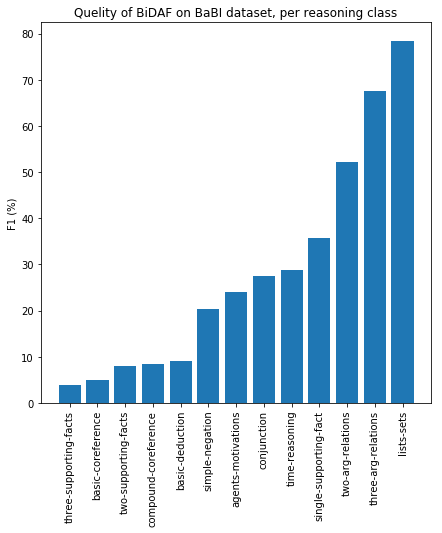

In [23]:
from evaluate11 import metric_max_over_ground_truths, f1_score, exact_match_score

# find the quality per reasoning type
scores = []
unique_types111 = set(bibi_reasoning_types)
for c in unique_types111:
    predictions_a = np.array([pred_ans_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
    labels_a = np.array([labels_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
    similarity = [f1_score(x,y) for x,y in zip(predictions_a, labels_a)]
    assert len(predictions_a) == len(labels_a)
    print(str(c) + " -> " + str(100.0 * sum(similarity) / len(predictions_a)))
    scores.append(100.0 * sum(similarity) / len(predictions_a))

similarity = [f1_score(x,y) for x,y in zip(pred_ans, labels)]


import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(7, 7))

scores_zipped_labels = list(zip(scores,unique_types111))
scores_zipped_labels.sort(key=lambda x: x[0])
scores22, unique_types22 = zip(*scores_zipped_labels)

plt.bar(range(len(scores22)), scores22)
# ax.plot(range(len(scores)), scores, 'o')
ax.set_ylabel('F1 (%)')
ax.set_title('Quelity of BiDAF on BaBI dataset, per reasoning class')
# ax.set_yticks(range(len(q_labels)))
# ax.set_xticks(range(len(bibi_reasoning_types)))
ax.set_xticks(np.arange(len(unique_types22)))

# ax.set_yticklabels(q_labels)
ax.set_xticklabels(unique_types22, rotation=90)
plt.show()

In [26]:
mat_concat = np.concatenate((mat, mat_ad), axis=0)
reasoning_types = ["squad"]*len(pred_ans) + bibi_reasoning_types
unique_reasoning_types = list(set(bibi_reasoning_types))
# unique_reasoning_types_indices = list(range(len(unique_reasoning_types)))
bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]
labels_concat = np.concatenate((labels, labels_ad))
pred_concat = np.concatenate((pred_ans, pred_ans_ad))

In [27]:
from sklearn.cluster import KMeans
db = KMeans(n_clusters=len(unique_reasoning_types), random_state=2).fit(mat_ad)
# db = DBSCAN(eps=0.3, min_samples=10).fit(mat_ad)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
labelsss = db.labels_

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

matt1 = confusion_matrix(bibi_reasoning_type_indices, labelsss)
max_values = np.max(matt1, axis=1)
max_indices = np.argmax(matt1, axis=1)
    

max_indices = list(enumerate(max_indices))
max_indices.sort(key=lambda x: x[1])
new_ordering = [x[0] for x in max_indices]

matt = matt1[new_ordering, :]

matt1, max_values, max_indices, new_ordering, matt1[new_ordering, :]

(array([[  0,   0,   0,   0,   0, 186,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 115,   3,   0,   0,   0,   0,   0, 169,   1,   1],
        [  0,   0,   0,  10,   0,   0,   8,   7,   2,   0,  94,   0,   9],
        [713,   0,   0,   0,   0,   0,   0,   0,   0, 286,   0,   0,   0],
        [  0,   0,   0,   0,  95,   0, 135,   1, 323,   0,  50,   0,   0],
        [  0,   0, 176,  15,   0,   0,   0, 245,   0,   0,   0,   0, 164],
        [  0,   0, 119,  87,   0,   0,   0, 260,   0,   0,   0,   0, 134],
        [  0,   0,  71, 118, 301,   0,   0,   0,   0,   0,   0, 243,  19],
        [  0, 321,   0,   2,  11,   0,   0,   0,   0,   0,   0,   1,  89],
        [  0,   0, 105,  54,   0,   0,   0, 311,   0,   0,   0,   0, 130],
        [  0,   0, 162,  20,   0,   0,   0, 265,   0,   0,   0,   0, 153],
        [  0,   0,  32, 189,  76,   0,   0,   0,   0,   0,   0,  66,  25],
        [  0,   0,   0,   1,   0,   0, 232,   0,   0,   0,  99,   0,   0]]),
 array([186, 169,  94, 

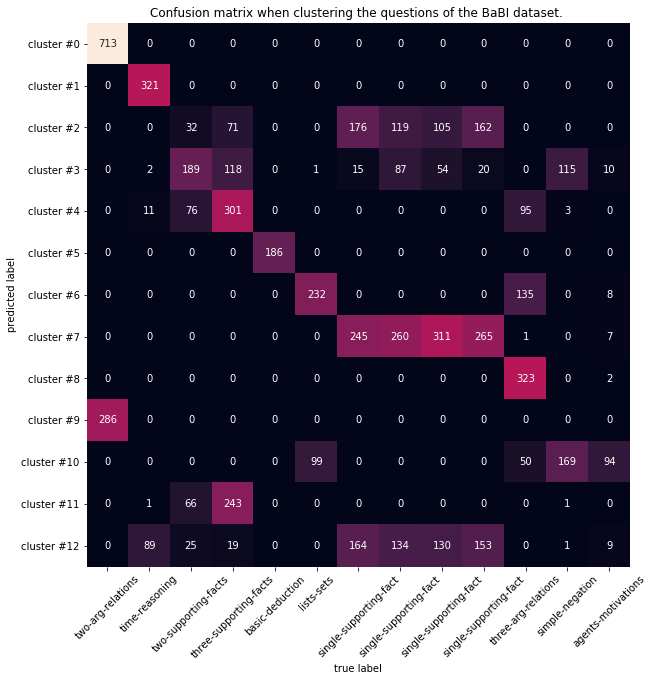

13
ars: 0.36046123193936175


In [29]:
plt.figure(figsize=(10, 10))
sss = sns.heatmap(matt.T, square=True,
            annot=True,
            fmt='d', cbar=False,
            xticklabels=True,
            yticklabels=True
            )

values, counts = np.unique(bibi_reasoning_types, return_counts=True)

count_per_label = dict(zip(counts, values))

new_label_ordering = [count_per_label[c] for c in np.sum(matt, axis=1)]

y_labels = ['cluster #' + str(i) for i in range(len(unique_reasoning_types))]
sss.set_xticklabels(new_label_ordering, rotation=45)
sss.set_yticklabels(y_labels, rotation=0)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix when clustering the questions of the BaBI dataset. ')
plt.show()
print(len(unique_reasoning_types))

ars = metrics.adjusted_rand_score(labelsss, bibi_reasoning_type_indices)
print("ars: " + str(ars))

In [64]:
# couts of the types  
values, counts = np.unique(bibi_reasoning_types, return_counts=True)

count_per_label = dict(zip(counts, values))

new_label_ordering = [count_per_label[c] for c in np.sum(matt, axis=1)]

values, counts,dict(zip(counts, values)), new_label_ordering

(array(['agents-motivations', 'basic-coreference', 'basic-deduction',
        'compound-coreference', 'conjunction', 'lists-sets',
        'simple-negation', 'single-supporting-fact', 'three-arg-relations',
        'three-supporting-facts', 'time-reasoning', 'two-arg-relations',
        'two-supporting-facts'], dtype='<U22'),
 array([130, 600, 186, 600, 600, 332, 289, 600, 604, 752, 424, 999, 388]),
 {130: 'agents-motivations',
  600: 'single-supporting-fact',
  186: 'basic-deduction',
  332: 'lists-sets',
  289: 'simple-negation',
  604: 'three-arg-relations',
  752: 'three-supporting-facts',
  424: 'time-reasoning',
  999: 'two-arg-relations',
  388: 'two-supporting-facts'},
 ['two-arg-relations',
  'time-reasoning',
  'two-supporting-facts',
  'three-supporting-facts',
  'basic-deduction',
  'lists-sets',
  'single-supporting-fact',
  'single-supporting-fact',
  'single-supporting-fact',
  'single-supporting-fact',
  'three-arg-relations',
  'agents-motivations',
  'simple-negation'

lists-sets -> 78.49535988565779
simple-negation -> 20.300111551383658
two-arg-relations -> 52.1950521950522
compound-coreference -> 8.451739352293382
agents-motivations -> 24.04645354645355
three-supporting-facts -> 3.8784005754064124
time-reasoning -> 28.775954581718683
basic-coreference -> 4.867682419284248
two-supporting-facts -> 7.996099424726351
conjunction -> 27.5323685213614
basic-deduction -> 9.035845915712434
single-supporting-fact -> 35.772348606559156
three-arg-relations -> 67.59088676155083


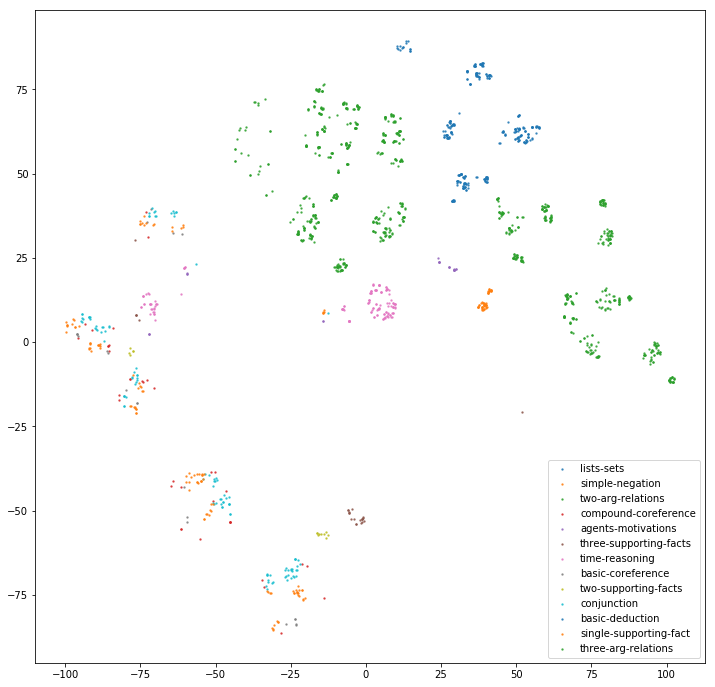

In [9]:
from evaluate11 import metric_max_over_ground_truths, f1_score, exact_match_score

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

(mat, labels, questions, pred_ans) = load_questions("ipython/babi/out3.txt", "ipython/babi/out22.txt", max_size=100)
(mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/babi/out33-adv.txt", "ipython/babi/out22-adv.txt", max_size=-1)

# read the questions and remember question ids:
question_paragraph_id_map = {}
ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/babi-test.json"
with open(ff) as file:
    dataset_json = json.load(file)
    dataset = dataset_json['data']
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                key = qa['question'] + paragraph['context']
                id = qa['id']
                question_paragraph_id_map[key] = id

bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]

# find the quality per reasoning type
for c in set(bibi_reasoning_types):
    predictions_a = np.array([pred_ans_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
    labels_a = np.array([labels_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
    similarity = [f1_score(x,y) for x,y in zip(predictions_a, labels_a)]
    assert len(predictions_a) == len(labels_a)
    print(str(c) + " -> " + str(100.0 * sum(similarity) / len(predictions_a)))

similarity = [f1_score(x,y) for x,y in zip(pred_ans, labels)]
# print("Squad -> ", str(100.0 * sum(similarity) / len(pred_ans)))


mat_concat = np.concatenate((mat, mat_ad), axis=0)
reasoning_types = ["squad"]*len(pred_ans) + bibi_reasoning_types
unique_reasoning_types = list(set(bibi_reasoning_types))
# unique_reasoning_types_indices = list(range(len(unique_reasoning_types)))
bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]
labels_concat = np.concatenate((labels, labels_ad))
pred_concat = np.concatenate((pred_ans, pred_ans_ad))

X_embedded = TSNE(n_components=2,init="pca").fit_transform(mat_concat)
fig, ax = plt.subplots(figsize=(12, 12))
for iter, c in enumerate(unique_reasoning_types):
    X_selected = np.asarray([X_embedded[i, :] for i, r in enumerate(reasoning_types) if r == c and f1_score(pred_concat[i], labels_concat[i]) > 0.6])
    plt.scatter(X_selected[:, 0], X_selected[:, 1], alpha=0.7, s=2, label=c) # color=color_map[iter],

ax.legend()
plt.show()

In [6]:
# clustering points into two groups 

(mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/babi/out33-adv.txt", "ipython/babi/out22-adv.txt", max_size=-1)



# read the questions and remember question ids:
question_paragraph_id_map = {}
ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/babi-test.json"
with open(ff) as file:
    dataset_json = json.load(file)
    dataset = dataset_json['data']
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                key = qa['question'] + paragraph['context']
                question_paragraph_id_map[key] = qa['id']

bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]
bibi_reasoning_types

['agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-mo

In [36]:
import numpy 

unique_reasoning_types = list(set(bibi_reasoning_types))

# bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]

ss = len(unique_reasoning_types)
accuracy_table = np.zeros(shape=(ss, ss)) 

for ind1, type1 in enumerate(unique_reasoning_types): 
    for ind2, type2 in enumerate(unique_reasoning_types):
        
#         if ind1 > 3 or ind2 >3: 
#             continue 
        
        # we want different types 
        if type1 == type2 or ind2 <= ind1: 
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 
        points = []
        labels = []
        for i, x in enumerate(bibi_reasoning_types): 
            if x == type1 or x == type2:
                points.append(mat_ad[i])
                labels.append(x)
        
        from sklearn.cluster import KMeans
        db = KMeans(n_clusters=2, random_state=2).fit(points)
        cluster_labels = db.labels_
        
        # calculate the confusion matrix 
        same_label_same_cluster = 0
        same_label_diff_cluster = 0
        diff_label_same_cluster = 0
        diff_label_diff_cluster = 0
        
        for ii in range(len(cluster_labels)):
            for jj in range(len(cluster_labels)):
                if ii == jj: 
                    continue 
                if cluster_labels[ii] == cluster_labels[jj] and labels[ii] == labels[jj]: 
                    same_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and labels[ii] == labels[jj]: 
                    same_label_diff_cluster += 1
                if cluster_labels[ii] == cluster_labels[jj] and labels[ii] != labels[jj]: 
                    diff_label_same_cluster += 1
                if cluster_labels[ii] == cluster_labels[jj] and labels[ii] != labels[jj]: 
                    diff_label_diff_cluster += 1
        total_pairs = same_label_same_cluster + same_label_diff_cluster + diff_label_same_cluster + diff_label_diff_cluster
        print("same_label_same_cluster: ", same_label_same_cluster / total_pairs, same_label_same_cluster)
        print("same_label_diff_cluster: ", same_label_diff_cluster / total_pairs, same_label_diff_cluster)
        print("diff_label_same_cluster: ", diff_label_same_cluster / total_pairs, diff_label_same_cluster)
        print("diff_label_diff_cluster: ", diff_label_diff_cluster / total_pairs, diff_label_diff_cluster)
        print("---------")
        accuracy_table[ind1][ind2] = (diff_label_diff_cluster + same_label_same_cluster) / total_pairs
        accuracy_table[ind2][ind1] = accuracy_table[ind1][ind2] 
accuracy_table

type1:  basic-coreference  type2:  single-supporting-fact
same_label_same_cluster:  0.25400344441103306 371668
same_label_diff_cluster:  0.2372351767310899 347132
diff_label_same_cluster:  0.25438068942893854 372220
diff_label_diff_cluster:  0.25438068942893854 372220
---------
type1:  basic-coreference  type2:  two-supporting-facts
same_label_same_cluster:  0.5875788121187313 413404
same_label_diff_cluster:  0.13666263012172172 96152
diff_label_same_cluster:  0.1378792788797735 97008
diff_label_diff_cluster:  0.1378792788797735 97008
---------
type1:  basic-coreference  type2:  three-arg-relations
same_label_same_cluster:  0.9950331399481 722406
same_label_diff_cluster:  0.0016611295681063123 1206
diff_label_same_cluster:  0.0016528652418968282 1200
diff_label_diff_cluster:  0.0016528652418968282 1200
---------
type1:  basic-coreference  type2:  compound-coreference
same_label_same_cluster:  0.2614273941364401 370520
same_label_diff_cluster:  0.24573554148180762 348280
diff_label_same

same_label_same_cluster:  0.9950331399481 722406
same_label_diff_cluster:  0.0016611295681063123 1206
diff_label_same_cluster:  0.0016528652418968282 1200
diff_label_diff_cluster:  0.0016528652418968282 1200
---------
type1:  three-arg-relations  type2:  lists-sets
same_label_same_cluster:  0.4462494840530561 320018
same_label_diff_cluster:  0.21486540757019668 154086
diff_label_same_cluster:  0.16944255418837362 121512
diff_label_diff_cluster:  0.16944255418837362 121512
---------
type1:  three-arg-relations  type2:  two-arg-relations
same_label_same_cluster:  0.9961895972048256 1360008
same_label_diff_cluster:  0.0008833805788120509 1206
diff_label_same_cluster:  0.001463511108181159 1998
diff_label_diff_cluster:  0.001463511108181159 1998
---------
type1:  three-arg-relations  type2:  time-reasoning
same_label_same_cluster:  0.44886703898165814 386760
same_label_diff_cluster:  0.1819840396640809 156804
diff_label_same_cluster:  0.1845744606771305 159036
diff_label_diff_cluster:  0.1

same_label_same_cluster:  0.6702461176323546 514808
same_label_diff_cluster:  0.173386382810303 133176
diff_label_same_cluster:  0.0781837497786712 60052
diff_label_diff_cluster:  0.0781837497786712 60052
---------
type1:  three-supporting-facts  type2:  agents-motivations
same_label_same_cluster:  0.6950338663893652 445140
same_label_diff_cluster:  0.21294448660177562 136382
diff_label_same_cluster:  0.04601082350442964 29468
diff_label_diff_cluster:  0.04601082350442964 29468
---------
type1:  three-supporting-facts  type2:  conjunction
same_label_same_cluster:  0.6794810689964956 792650
same_label_diff_cluster:  0.11272707946152422 131502
diff_label_same_cluster:  0.10389592577099006 121200
diff_label_diff_cluster:  0.10389592577099006 121200
---------
type1:  three-supporting-facts  type2:  basic-deduction
same_label_same_cluster:  1.0 599162
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.0 0
---------
type1:  simple-negation  type2:  ag

array([[0.        , 0.50838413, 0.72545809, 0.99668601, 0.50784593,
        1.        , 1.        , 0.77878706, 0.78185588, 0.85222407,
        0.95423816, 0.50589387, 1.        ],
       [0.50838413, 0.        , 0.67228074, 0.99668601, 0.50504432,
        1.        , 1.        , 0.77878706, 0.78185588, 0.76254505,
        0.717244  , 0.50297803, 1.        ],
       [0.72545809, 0.67228074, 0.        , 1.        , 0.80545077,
        1.        , 1.        , 0.62510531, 0.61366863, 1.        ,
        0.5285914 , 0.80098854, 1.        ],
       [0.99668601, 0.99668601, 1.        , 0.        , 0.99668601,
        0.61569204, 0.99765311, 0.6334415 , 1.        , 0.59954069,
        0.5678172 , 0.99668601, 0.58356582],
       [0.50784593, 0.50504432, 0.80545077, 0.99668601, 0.        ,
        1.        , 1.        , 0.77103167, 0.78337699, 0.97643071,
        0.9574487 , 0.50312379, 1.        ],
       [1.        , 1.        , 1.        , 0.61569204, 1.        ,
        0.        , 1.     

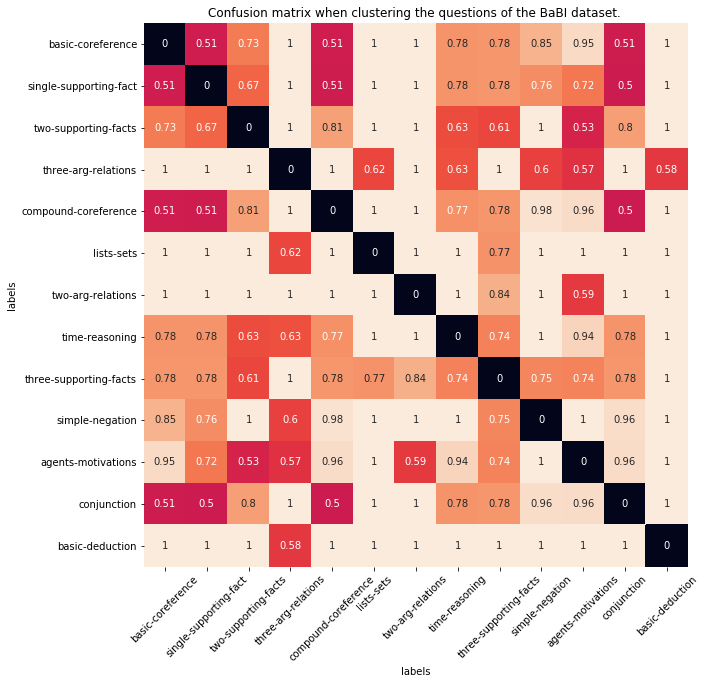

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))
sss = sns.heatmap(accuracy_table, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_reasoning_types, rotation=45)
sss.set_yticklabels(unique_reasoning_types, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Confusion matrix when clustering the questions of the BaBI dataset. ')
plt.show()

In [102]:
from sklearn.cluster import SpectralClustering

# Cluster
cluster_size = 3
sc = SpectralClustering(cluster_size, affinity='precomputed')
# sc.fit(accuracy_table > 0.9)
# cluster_labels = sc.labels_
# cluster_labels

# db = KMeans(n_clusters=cluster_size, random_state=2).fit(accuracy_table > 0.8)
# db = DBSCAN(eps=0.3, min_samples=10, affinity='precomputed').fit(accuracy_table > 0.9)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
cluster_labels = db.labels_

Type basic-coreference in cluster 0 
Type single-supporting-fact in cluster 0 
Type two-supporting-facts in cluster 0 
Type compound-coreference in cluster 0 
Type time-reasoning in cluster 0 
Type three-supporting-facts in cluster 0 
Type conjunction in cluster 0 
Type three-arg-relations in cluster 1 
Type lists-sets in cluster 1 
Type simple-negation in cluster 1 
Type basic-deduction in cluster 1 
Type two-arg-relations in cluster 2 
Type agents-motivations in cluster 2 


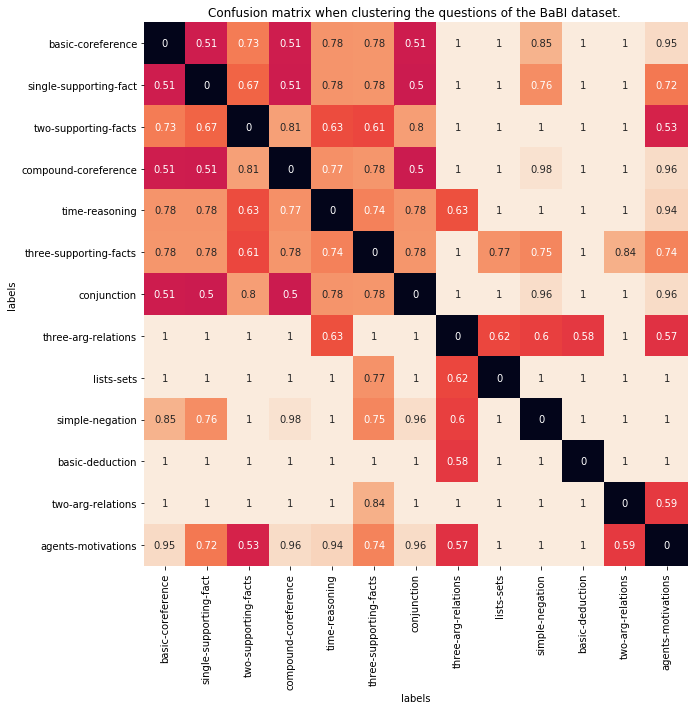

In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

unique_reasoning_types_new_ordering = []
new_to_old_type_map = {}
for cluster_id in range(cluster_size): 
    for label_id in range(len(cluster_labels)): 
        if cluster_labels[label_id] == cluster_id: 
            print(f"Type {unique_reasoning_types[label_id]} in cluster {cluster_id} ")
            new_id = len(unique_reasoning_types_new_ordering)
            new_to_old_type_map[new_id] = label_id
            unique_reasoning_types_new_ordering.append(unique_reasoning_types[label_id])
            
unique_reasoning_types_new_ordering, new_to_old_type_map

accuracy_table_new = np.zeros(shape=(ss, ss)) 

for new_id1 in range(len(unique_reasoning_types_new_ordering)): 
    for new_id2 in range(len(unique_reasoning_types_new_ordering)):
        id1 = new_to_old_type_map[new_id1]
        id2 = new_to_old_type_map[new_id2]
        accuracy_table_new[new_id1][new_id2] = accuracy_table[id1][id2]
    

plt.figure(figsize=(10, 10))
sss = sns.heatmap(accuracy_table_new, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_reasoning_types_new_ordering, rotation=90)
sss.set_yticklabels(unique_reasoning_types_new_ordering, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Confusion matrix when clustering the questions of the BaBI dataset. ')
plt.show()

array([[0.        , 0.80545077, 1.        , 1.        , 0.80098854,
        0.72545809, 0.67228074, 1.        , 0.61366863, 1.        ,
        0.62510531, 0.5285914 , 1.        ],
       [0.80545077, 0.        , 1.        , 0.97643071, 0.50312379,
        0.50784593, 0.50504432, 0.99668601, 0.78337699, 1.        ,
        0.77103167, 0.9574487 , 1.        ],
       [1.        , 1.        , 0.        , 0.99762596, 1.        ,
        1.        , 1.        , 0.99765311, 0.84439423, 1.        ,
        1.        , 0.5859797 , 1.        ],
       [1.        , 0.97643071, 0.99762596, 0.        , 0.9612939 ,
        0.85222407, 0.76254505, 0.59954069, 0.74842987, 1.        ,
        1.        , 1.        , 1.        ],
       [0.80098854, 0.50312379, 1.        , 0.9612939 , 0.        ,
        0.50589387, 0.50297803, 0.99668601, 0.78337699, 1.        ,
        0.77878706, 0.9574487 , 1.        ],
       [0.72545809, 0.50784593, 1.        , 0.85222407, 0.50589387,
        0.        , 0.50838